In [133]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Function to set the seed for reproducibility
def set_seed(seed_value):
    np.random.seed(seed_value)

seed_value = 42  # You can modify this value
set_seed(seed_value)  # Set the seed for reproducibility

# Ensure inline plotting in Jupyter
%matplotlib inline


In [134]:
# Function to load all images from the current folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Only process .jpg files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
                print(f"Loaded image: {filename}")  # Debug: Print the image loaded
            else:
                print(f"Failed to load image: {filename}")  # Debug: Failed loading
    return images

folder = './Ass2'  # Path to your images folder
images = load_images_from_folder(folder)

if not images:
    print("No images found in the folder.")


Loaded image: T22.jpg
Loaded image: T32.jpg
Loaded image: T42.jpg
Loaded image: T52.jpg
Loaded image: T62.jpg


In [135]:
# Otsu’s Method Multilevel Thresholding
def otsu_multilevel_thresholding(image, levels):
    thresholds = []
    current_image = image.copy()

    for _ in range(levels - 1):
        thresh_value, _ = cv2.threshold(current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_value)
        current_image = np.where(current_image >= thresh_value, 0, current_image)

    segmented_image = np.zeros_like(image)
    for i, thresh in enumerate(sorted(thresholds)):
        segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

    return segmented_image, thresholds

def kapur_threshold(image, levels):
    hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
    hist = hist.astype(np.float32) / hist.sum()

    def entropy(thresh):
        prob1 = hist[:thresh].sum()
        prob2 = hist[thresh:].sum()
        prob1 = prob1 if prob1 > 0 else 1
        prob2 = prob2 if prob2 > 0 else 1
        return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

    thresholds = []
    for _ in range(levels - 1):
        entropies = [entropy(thresh) for thresh in range(1, 255)]
        best_thresh = np.argmax(entropies)
        thresholds.append(best_thresh)

    segmented_image = np.zeros_like(image)
    for i, thresh in enumerate(sorted(thresholds)):
        segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

    return segmented_image, thresholds

# Kapur’s Method Thresholding (maximizes entropy)
# def kapur_threshold(image, levels):
#     hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
#     hist = hist.astype(np.float32) / hist.sum()

#     def entropy(thresh):
#         prob1 = hist[:thresh].sum()
#         prob2 = hist[thresh:].sum()
#         prob1 = prob1 if prob1 > 0 else 1
#         prob2 = prob2 if prob2 > 0 else 1
#         return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

#     thresholds = []
#     for _ in range(levels - 1):
#         entropies = [entropy(thresh) for thresh in range(1, 255)]
#         best_thresh = np.argmax(entropies)
#         thresholds.append(best_thresh)
#         image = np.where(image >= best_thresh, 0, image)  # Update image based on the threshold

#     segmented_image = np.zeros_like(image)
#     for i, thresh in enumerate(sorted(thresholds)):
#         segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

#     return segmented_image, thresholds




# Kapur’s Method Thresholding (maximizes entropy)
# def kapur_threshold(image, levels):
#     hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
#     hist_sum = hist.sum()

#     # Ensure sum is non-zero before normalizing
#     if hist_sum > 0:
#         hist = hist.astype(np.float32) / hist_sum
#     else:
#         hist = np.zeros_like(hist, dtype=np.float32)  # If the sum is 0, set hist to zeros

#     def entropy(thresh):
#         prob1 = hist[:thresh].sum()
#         prob2 = hist[thresh:].sum()
#         prob1 = prob1 if prob1 > 0 else 1  # Prevent log(0) by setting a lower bound
#         prob2 = prob2 if prob2 > 0 else 1
#         return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

#     thresholds = []
#     for _ in range(levels - 1):
#         entropies = [entropy(thresh) for thresh in range(1, 255)]
#         best_thresh = np.argmax(entropies)
#         thresholds.append(best_thresh)
#         image = np.where(image >= best_thresh, 0, image)

#     segmented_image = np.zeros_like(image)
#     for i, thresh in enumerate(sorted(thresholds)):
#         segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

#     return segmented_image, thresholds


# Kapur’s Method Thresholding (maximizes entropy)
# def kapur_threshold(image, levels):
#     hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
#     hist = hist.astype(np.float32) / hist.sum()

#     def entropy(thresh):
#         prob1 = hist[:thresh].sum()
#         prob2 = hist[thresh:].sum()
#         prob1 = prob1 if prob1 > 0 else 1
#         prob2 = prob2 if prob2 > 0 else 1
#         return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

#     thresholds = []
#     for _ in range(levels - 1):
#         entropies = [entropy(thresh) for thresh in range(1, 255)]
#         best_thresh = np.argmax(entropies)
#         thresholds.append(best_thresh)
#         image = np.where(image >= best_thresh, 0, image)

#     segmented_image = np.zeros_like(image)
#     for i, thresh in enumerate(sorted(thresholds)):
#         segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

#     return segmented_image, thresholds


In [136]:
# Simulated Annealing for Thresholding Optimization
def simulated_annealing(image, objective_function, levels, initial_temperature=1000, cooling_rate=0.95):
    def perturb(thresholds):
        idx = np.random.randint(0, len(thresholds))
        thresholds[idx] += np.random.randint(-10, 10)
        thresholds = np.clip(thresholds, 0, 255)
        return thresholds

    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    current_cost = objective_function(image, current_thresholds)
    temperature = initial_temperature

    while temperature > 1:
        new_thresholds = perturb(current_thresholds.copy())
        new_cost = objective_function(image, new_thresholds)

        if new_cost < current_cost or np.random.random() < np.exp((current_cost - new_cost) / temperature):
            current_thresholds = new_thresholds
            current_cost = new_cost

        temperature *= cooling_rate

    return current_thresholds

# Variable Neighbourhood Search for Thresholding Optimization
def vns(image, objective_function, levels):
    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    best_cost = objective_function(image, current_thresholds)

    def local_search(thresholds):
        for i in range(len(thresholds)):
            for change in [-5, 5]:
                new_thresholds = thresholds.copy()
                new_thresholds[i] += change
                new_thresholds = np.clip(new_thresholds, 0, 255)
                new_cost = objective_function(image, new_thresholds)
                if new_cost < best_cost:
                    return new_thresholds, new_cost
        return thresholds, best_cost

    while True:
        new_thresholds, new_cost = local_search(current_thresholds)
        if new_cost < best_cost:
            current_thresholds = new_thresholds
            best_cost = new_cost
        else:
            break

    return current_thresholds


In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Display images in a grid, applying a colormap to segmented images
def display_images(images, titles, cols=2, figsize=(5, 3)):  # Adjusted figsize for smaller images
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # If there's only one row, axes might not be an array. Handle that case.
    if rows == 1:
        axes = [axes]
        
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            if 'segmented' in titles[i].lower() and np.unique(images[i]).size > 2:
                ax.imshow(images[i], cmap='jet')  # Use 'jet' colormap for segmentation
            else:
                ax.imshow(images[i], cmap='gray')  # Use grayscale for original image
            ax.set_title(titles[i], fontsize=8)  # Reduced title font size for smaller images
        else:
            ax.axis('off')  # Hide unused subplots
        ax.axis('off')  # Turn off the axis ticks
    plt.tight_layout()
    plt.show()

# Logging function to print and store results
def log_results(df, image_name, level, method, optimization, thresholds, obj_value, ssim_value, psnr_value):
    new_row = pd.DataFrame({
        'Image': [image_name], 
        'Level': [level], 
        'Method': [method], 
        'Optimization': [optimization], 
        'Thresholds': [thresholds], 
        'Objective Value': [obj_value], 
        'SSIM': [ssim_value], 
        'PSNR': [psnr_value]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    return df


# Objective function (Otsu)
def otsu_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_var = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        region = image[mask]
        if len(region) > 0:
            total_var += np.var(region) * len(region)
    return total_var

# Objective function (Kapur)
def kapur_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_entropy = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        hist, _ = np.histogram(image[mask], bins=256, range=[0, 256])
        hist = hist.astype(np.float32) / hist.sum()
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        total_entropy += entropy
    return -total_entropy


# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])


Processing image: T22.jpg
Processing k=2


C:\Users\seans\AppData\Local\Temp\ipykernel_55048\2995012870.py:60: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Processing k=3
Processing k=4
Processing k=5


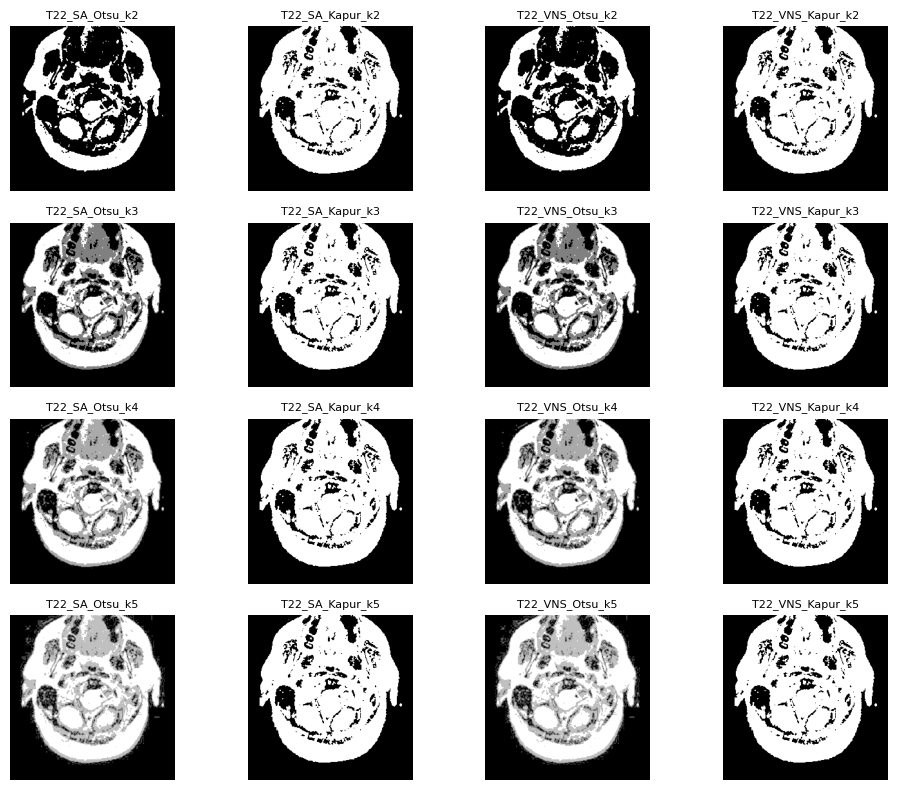

Processing image: T32.jpg
Processing k=2
Processing k=3
Processing k=4
Processing k=5


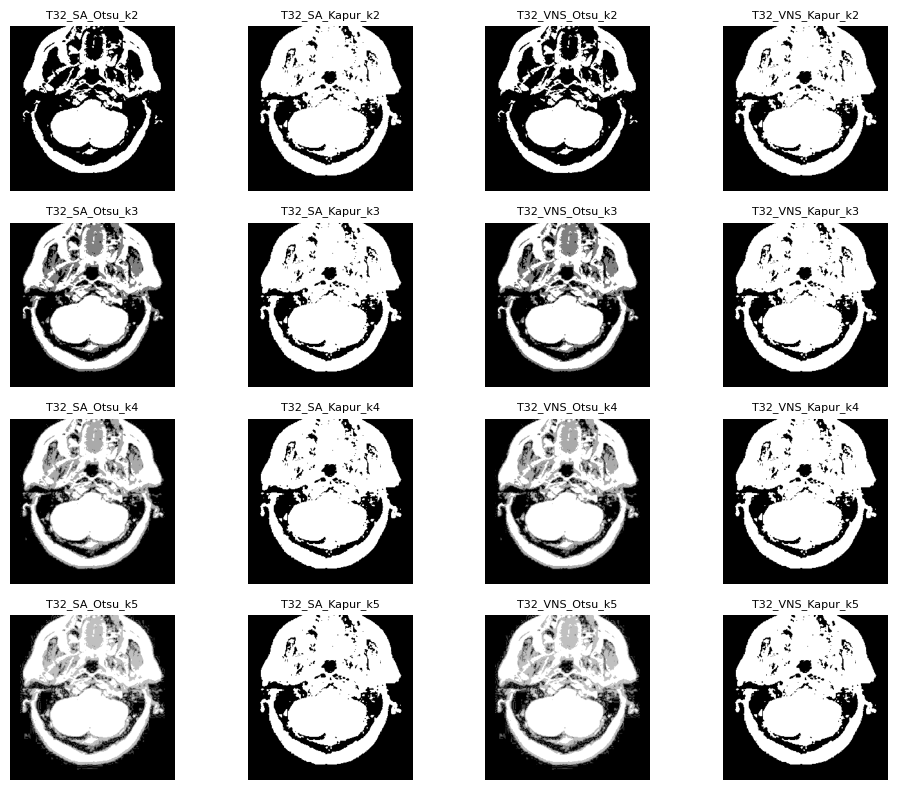

Processing image: T42.jpg
Processing k=2
Processing k=3
Processing k=4
Processing k=5


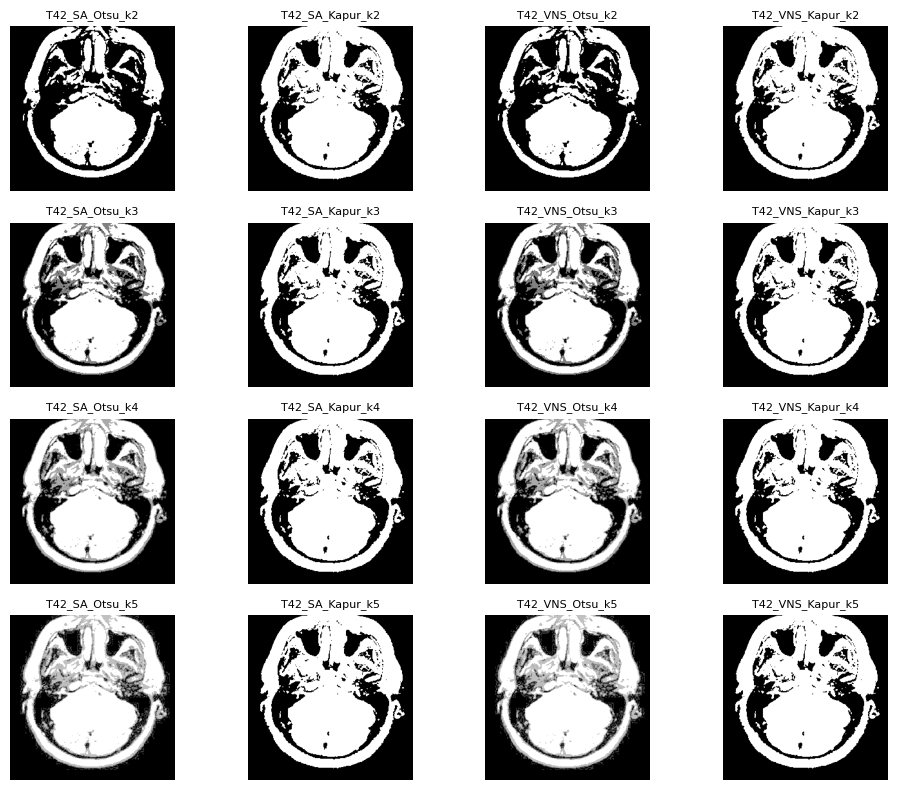

Processing image: T52.jpg
Processing k=2
Processing k=3
Processing k=4
Processing k=5


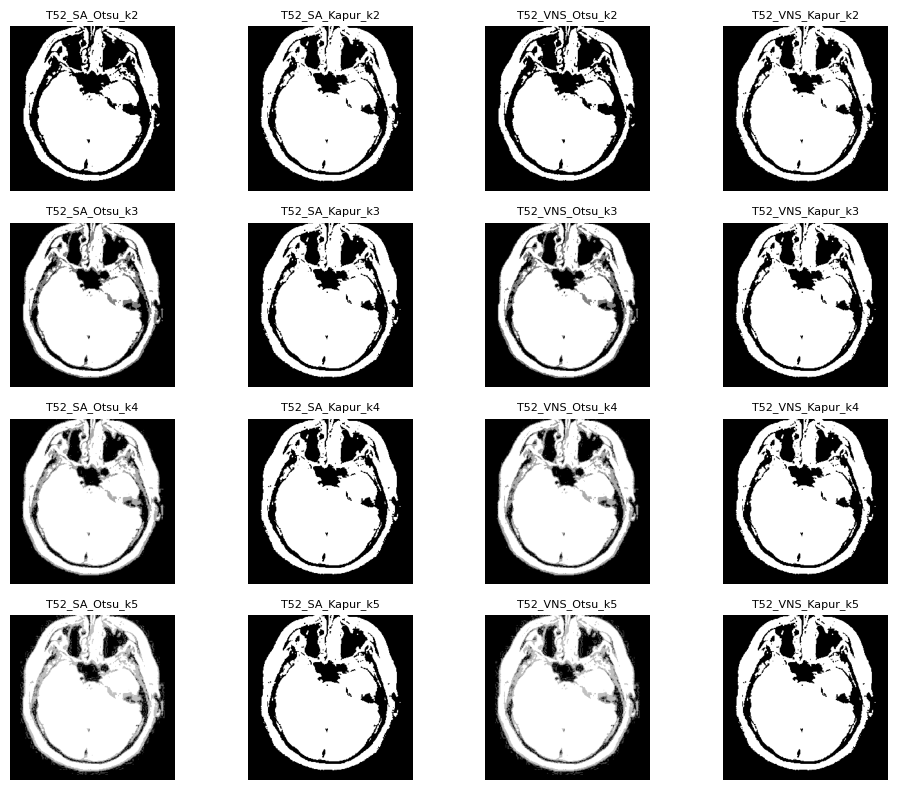

Processing image: T62.jpg
Processing k=2
Processing k=3
Processing k=4
Processing k=5


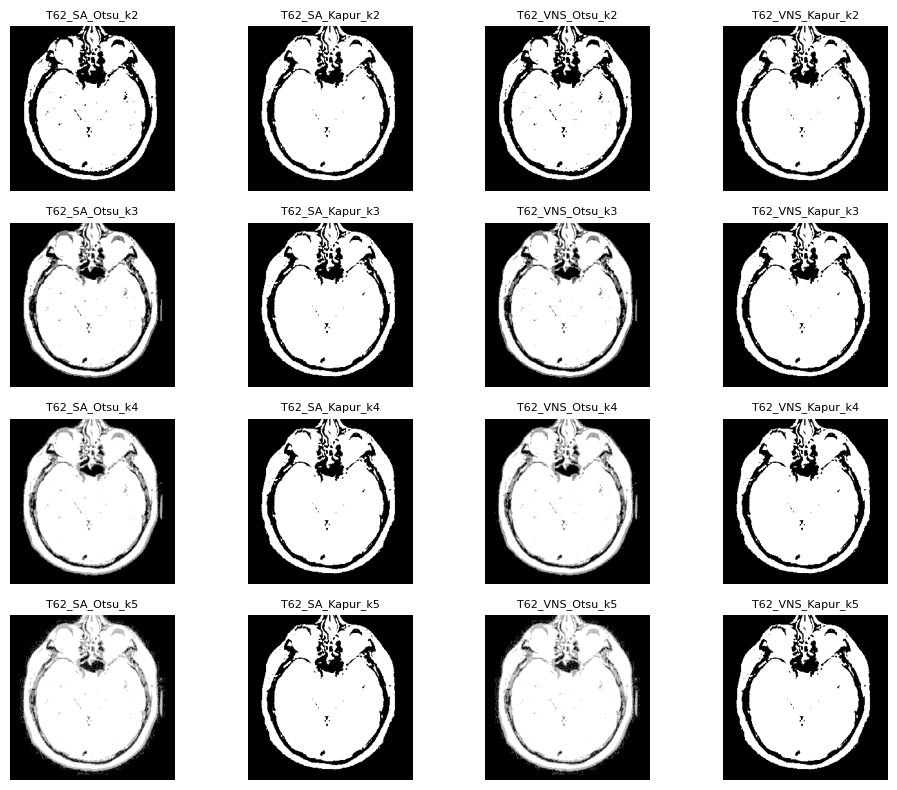

In [138]:
import matplotlib.pyplot as plt

# Function to plot the histogram of the image
def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, range=[0,256], color='blue', alpha=0.7)
    plt.title(f'Gray Level Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Main execution block for image processing without saving images
for filename, image in images:
    name_without_extension = os.path.splitext(filename)[0]
    print(f"Processing image: {filename}")
    
    processed_images = []  # List to store processed images across multiple k
    image_titles = []      # List to store titles of images
    
    # Loop through different k levels (e.g., k=2, k=3, etc.)
    for k in [2, 3, 4, 5]:
        print(f"Processing k={k}")
        
        # Simulated Annealing + Otsu
        sa_thresholds = simulated_annealing(image, otsu_objective, k)
        segmented_sa_otsu, _ = otsu_multilevel_thresholding(image, len(sa_thresholds) + 1)
        processed_images.append(segmented_sa_otsu)
        image_titles.append(f'{name_without_extension}_SA_Otsu_k{k}')
        
        # Simulated Annealing + Kapur
        sa_thresholds = simulated_annealing(image, kapur_objective, k)
        segmented_sa_kapur, _ = kapur_threshold(image, len(sa_thresholds) + 1)
        processed_images.append(segmented_sa_kapur)
        image_titles.append(f'{name_without_extension}_SA_Kapur_k{k}')

        # Variable Neighbourhood Search + Otsu
        vns_thresholds = vns(image, otsu_objective, k)
        segmented_vns_otsu, _ = otsu_multilevel_thresholding(image, len(vns_thresholds) + 1)
        processed_images.append(segmented_vns_otsu)
        image_titles.append(f'{name_without_extension}_VNS_Otsu_k{k}')
        
        # Variable Neighbourhood Search + Kapur
        vns_thresholds = vns(image, kapur_objective, k)
        segmented_vns_kapur, _ = kapur_threshold(image, len(vns_thresholds) + 1)
        processed_images.append(segmented_vns_kapur)
        image_titles.append(f'{name_without_extension}_VNS_Kapur_k{k}')

    # Call the display_images function to show processed images side by side in a grid format
    # Adjust the cols parameter to display multiple images in one row
    display_images(processed_images, image_titles, cols=4, figsize=(10, 8))  # This displays in a grid of 4 images per row


                                                                                                                                                